In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, norm

In [2]:
# To study the distribution of the predictor `RAT AGE AT LATEST ARREST`,
# we need a function to convert it to a continuous variable.
def age_converter(agestring):
    if agestring=='less than 20':
        return 0.
    else:
        return (float(agestring[0]) - 1)

In [3]:
df = pd.read_csv("Strategic_Subject_List.csv", low_memory=False)
predictors = df[['SSL SCORE','PREDICTOR RAT AGE AT LATEST ARREST', 'PREDICTOR RAT VICTIM SHOOTING INCIDENTS', 'PREDICTOR RAT VICTIM BATTERY OR ASSAULT', 'PREDICTOR RAT ARRESTS VIOLENT OFFENSES', 'PREDICTOR RAT GANG AFFILIATION','PREDICTOR RAT NARCOTIC ARRESTS','PREDICTOR RAT TREND IN CRIMINAL ACTIVITY','PREDICTOR RAT UUW ARRESTS']]
predictors = predictors.dropna()
predictors['PREDICTOR RAT AGE AT LATEST ARREST'] = predictors['PREDICTOR RAT AGE AT LATEST ARREST'].apply(age_converter)

# 1. The distributions of SSL score and its 8 predictor variables

The SSL scores are computed using an algorithm which takes the following eight fields as inputs.
<ol>
    <li>'PREDICTOR RAT AGE AT LATEST ARREST'
    <li>'PREDICTOR RAT VICTIM SHOOTING INCIDENTS'
    <li>'PREDICTOR RAT VICTIM BATTERY OR ASSAULT'
    <li>'PREDICTOR RAT ARRESTS VIOLENT OFFENSES'
    <li>'PREDICTOR RAT GANG AFFILIATION'
    <li>'PREDICTOR RAT NARCOTIC ARRESTS'
    <li>'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY'
    <li>'PREDICTOR RAT UUW ARRESTS'
</ol>
The distributions of SSL Scores and the above variables are plotted below. Predictors 2-4, 6, and 8 are heavily skewed right. Visibility is improved a little by putting them on a log-scale. Normalizing predictor 7 is unhelpful due to the existence of extreme outliers.

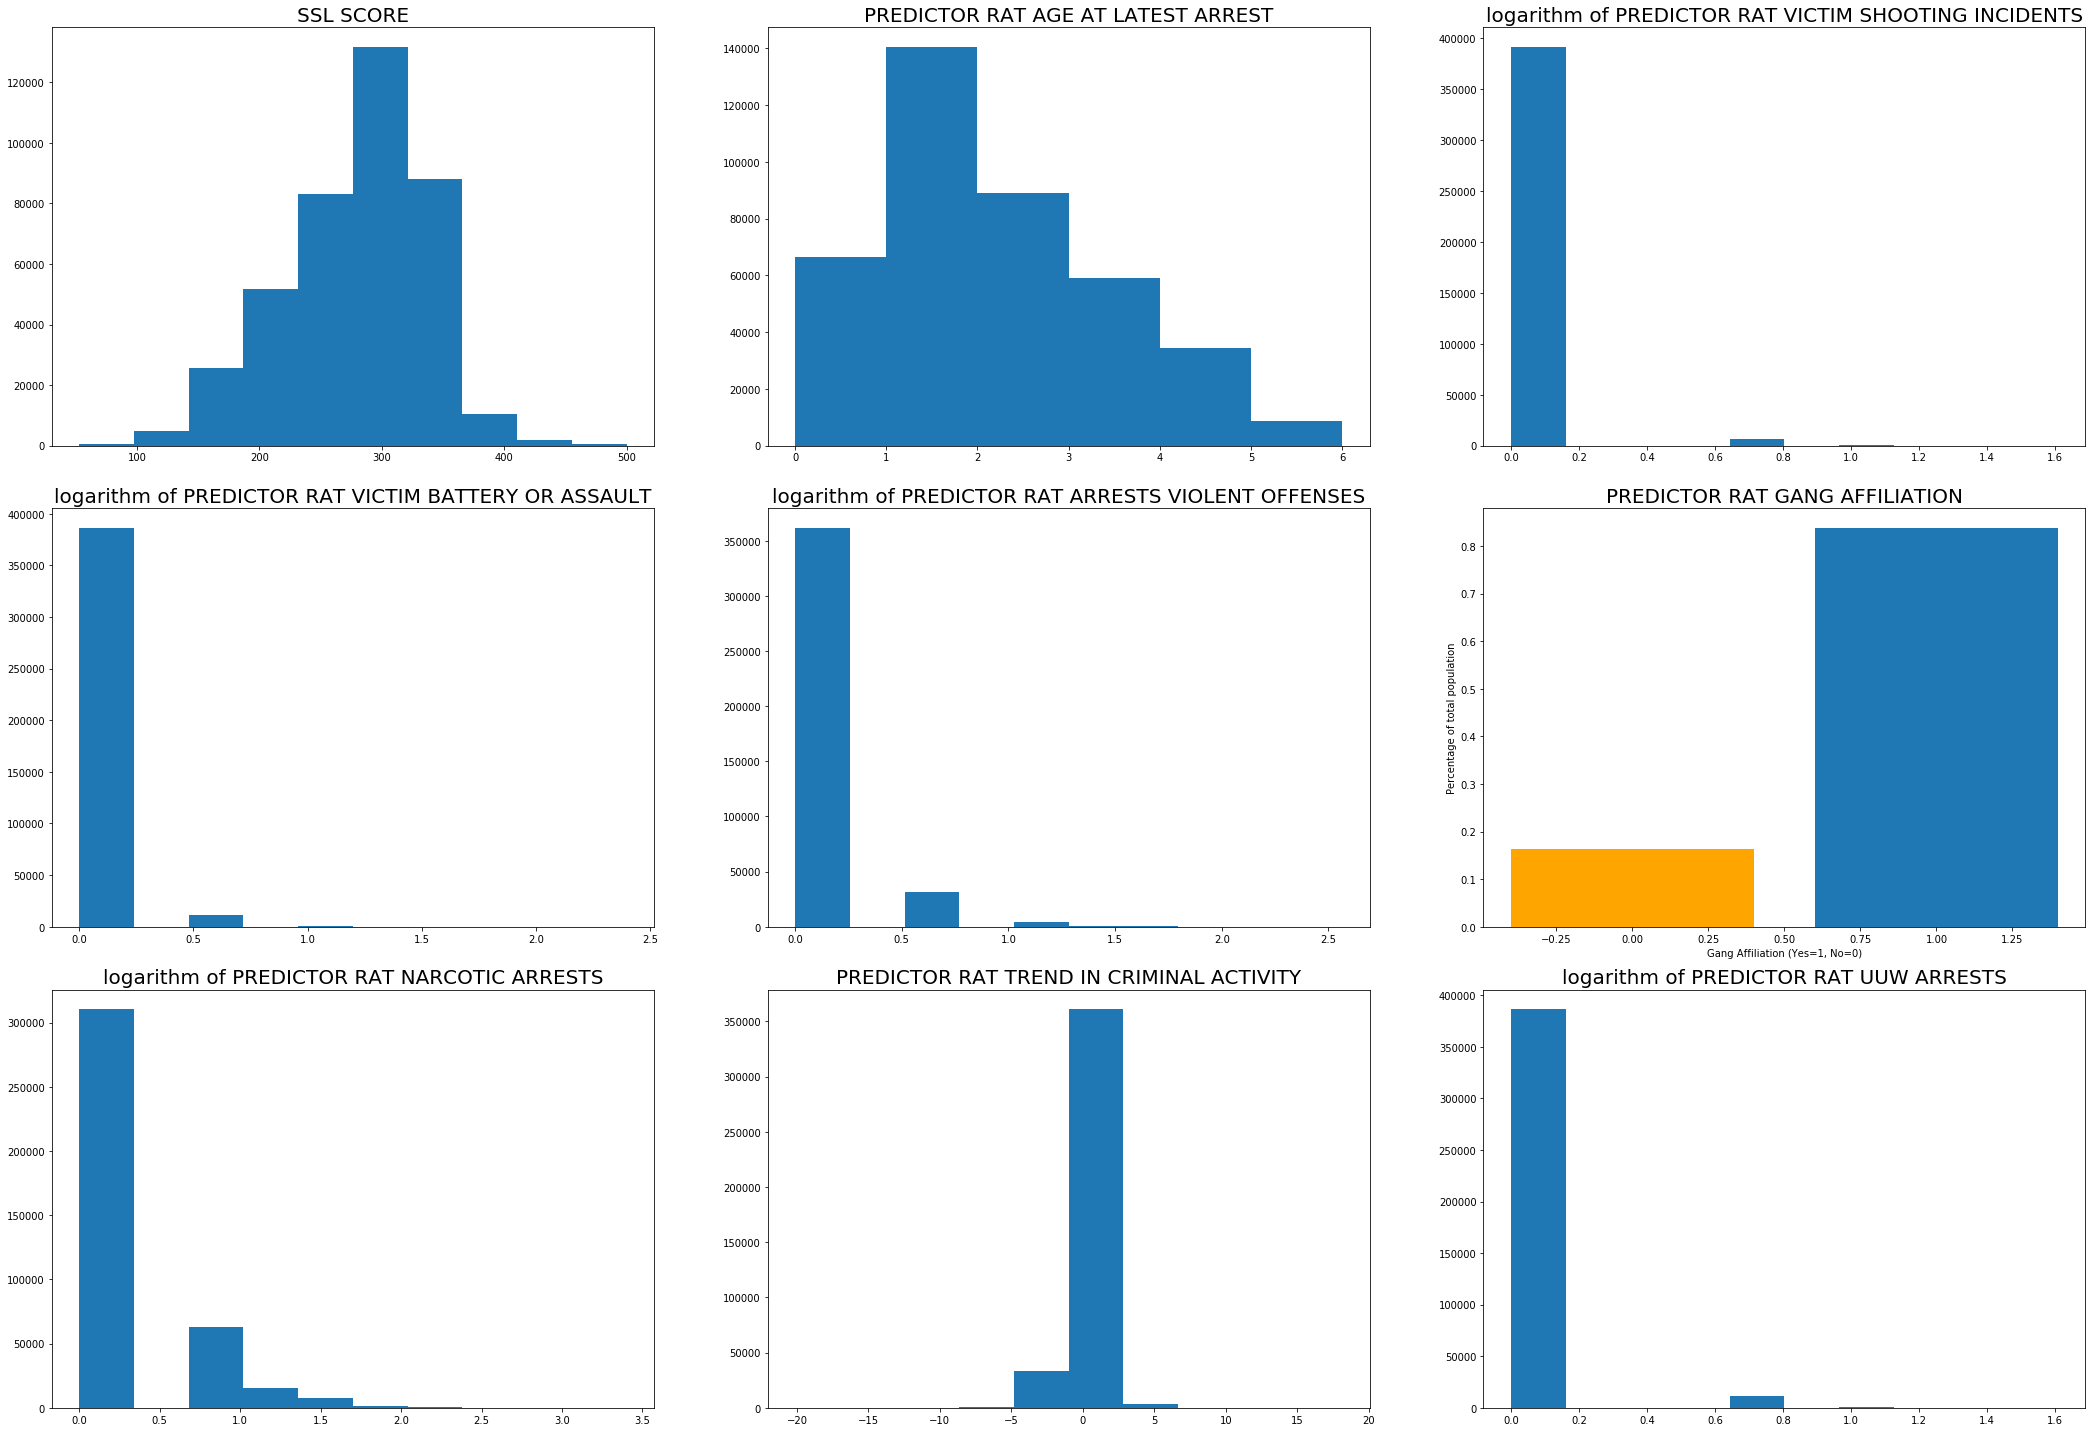

In [4]:
plt.subplots(figsize=(30, 20))
scaler = StandardScaler()

for i,column in enumerate(predictors.columns):
    plt.subplot(3,3,i+1)
    if column == 'PREDICTOR RAT AGE AT LATEST ARREST':
        plt.hist(predictors[column].values, bins = 6)
        plt.title(column, fontsize=20)
    elif (i>=2 and i<= 4) or (i==6 or i==8):
        plt.hist(np.log(predictors[column].values + 1))
        plt.title("logarithm of " + column, fontsize=20)
    elif i==5:
        gang_affiliation = predictors[column].values
        percent_gang_affiliated = np.sum(gang_affiliation)/len(gang_affiliation)
        plt.bar([0,1], [percent_gang_affiliated, 1 - percent_gang_affiliated], color=['orange','#1f77b4'])
        plt.title(column, fontsize=20)
        plt.ylabel('Percentage of total population')
        plt.xlabel('Gang Affiliation (Yes=1, No=0)')
    elif i==7:
        trends = predictors[column].values.reshape(-1,1)
        scaler.fit(trends)
        plt.hist(scaler.transform(trends))
        plt.title(column, fontsize=20)
    else:
        plt.hist(predictors[column].values)
        plt.title(column,fontsize=20)
    
plt.tight_layout()
plt.show()

## 1.1 SSL scores: a summary
SSL Scores have minimum $53$, maximum $500$, mean $279.90$, and standard deviation $57.88$. They fail a normality test. 153 individuals have the maximum score of $500$, while only $132$ have scores between $480$ and $499$, suggesting some degree of bunching at the right tail. 95% of individuals have an SSL score between $157$ and $372$.

In [5]:
ssl_scores = predictors['SSL SCORE'].values
ssl_scores.min(), ssl_scores.max(), ssl_scores.mean(), ssl_scores.std(), normaltest(ssl_scores), np.percentile(ssl_scores, [2.5, 97.5])


(53,
 500,
 279.89994530611017,
 57.88042413673477,
 NormaltestResult(statistic=12791.643391470816, pvalue=0.0),
 array([157., 372.]))

# 2. Exploring a model of `PREDICTOR RAT TREND IN CRIMINAL ACTIVITY`
The way this field is computed is unknown. A model for how it is computed will eventually factor in to our analysis. Below, we study its distribution, which is interesting. Summary statistics are displayed below. The distribution fails a normality test. $95$% of the data lies between $-.9$ and $.7$, and $99$% of the data between $-1.6$ and $1.3$. However, the distribution has many extreme outliers. The maximum and minimum are both approximately twenty standard deviations from the mean, and there are $238$ values 8 or more standard deviations from the mean.

In [6]:
trends = predictors['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY'].values
trends.min(), trends.max(), trends.mean(), trends.std(), normaltest(trends), np.percentile(trends, [.25, 99.75])

(-8.2,
 7.3,
 -0.04954463573367589,
 0.4049217515008507,
 NormaltestResult(statistic=95133.55449293683, pvalue=0.0),
 array([-2. ,  1.6]))

In [7]:
# num. of vals. 8 or more sdevs from the mean, probability of witnessing such a value in normal. dist.
np.sum(trends <= trends.mean() - 8*trends.std()) + np.sum(trends >= trends.mean() + 8*trends.std()),\
    1 - norm.cdf(8., loc=0, scale=1)

(238, 6.661338147750939e-16)

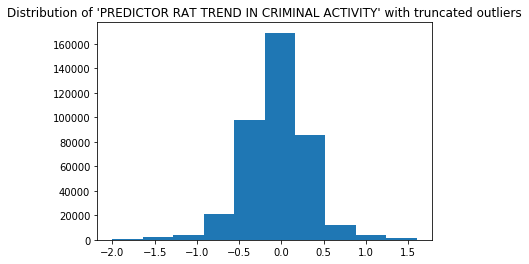

In [8]:
plt.hist(np.sort(trends)[1000:-1000])
plt.title("Distribution of 'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY' with truncated outliers")
plt.show()

# 2. Exploring a model of `PREDICTOR RAT TREND IN CRIMINAL ACTIVITY` (cont.)
Our model of the trend variable will employ the 7 other direct inputs, and the 44 other fields which are not direct inputs. Of these other 44, 8 stand out as possibly relevant to computing the trend variable. They are:

<ol>
<li>'LATEST DATE': (latest date of police contact)
<li>'WEAPONS ARR CNT' (counts are computed from arrests in last 10 years)
<li>'LATEST WEAPON ARR DATE'
<li>'NARCOTICS ARR CNT'
<li>'LATEST NARCOTIC ARR DATE’
<li>'DOMESTIC ARR CNT'
<li>'LATEST DOMESTIC ARR DATE'
<li>'SSL LAST PTV DATE' (from the third footnote: “Most recent date that the subject was matched with a victim or arrest record making the subject a ‘Party to Violence’)
</ol>

## 2.1 `LATEST DATE` vs. Trend in Criminal Activity
The below box plot indicates that the vast majority of subjects have a trend in criminal activity ('trend') near $0$, regards of the year of their latest police contact ('year'). There is a slight positive correlation between 'trend' and 'year' of .4712, with a $p$ value of $0$.

Yet it is possible that not all police contact is bad for one's 'trend'. In the year 2016, for example, many subjects have an incredibly low 'trend' value that coincides with a recent date of police contact. It is unknown what qualifies as police contact: an arrest might warrant an increase in 'trend', whereas an interview leading the CPD to conclude a subject is no longer gang affiliated, for instance, might warrant a decrease in 'trend'.

Per Upturn<sup>1</sup>:
> The CPD claims the SSL is used in conjunction another program, called Custom Notifications (Special Order S10–05), where police officers, social workers, and community leaders “deliver a joint message ... informing [people on the list] of their risk for prosecution based on criminal history, and explaining their opportunities for community help and support.” The CPD itself describes Custom Notifications as “a process that identifies potential criminal actors and victims associated with the continuum of violence. Once identified, the individual is notified of the consequences that will result should violent activity continue.” Between 2013 and 2016, the CPD is reported to have made over 1,400 of these visits.”

**Question**: What constitutes "Police Contact?"

**Question**: What happens to an individuals SSL score when they are incarcerated? Are they removed from the list?

<sup>1</sup>https://medium.com/equal-future/how-strategic-is-chicagos-strategic-subjects-list-upturn-investigates-9e5b4b235a7c

In [9]:
from scipy.stats import pearsonr
latest_r = pearsonr(df['LATEST DATE'].values, df['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY'].values)
latest_r

(0.4712743031738869, 0.0)

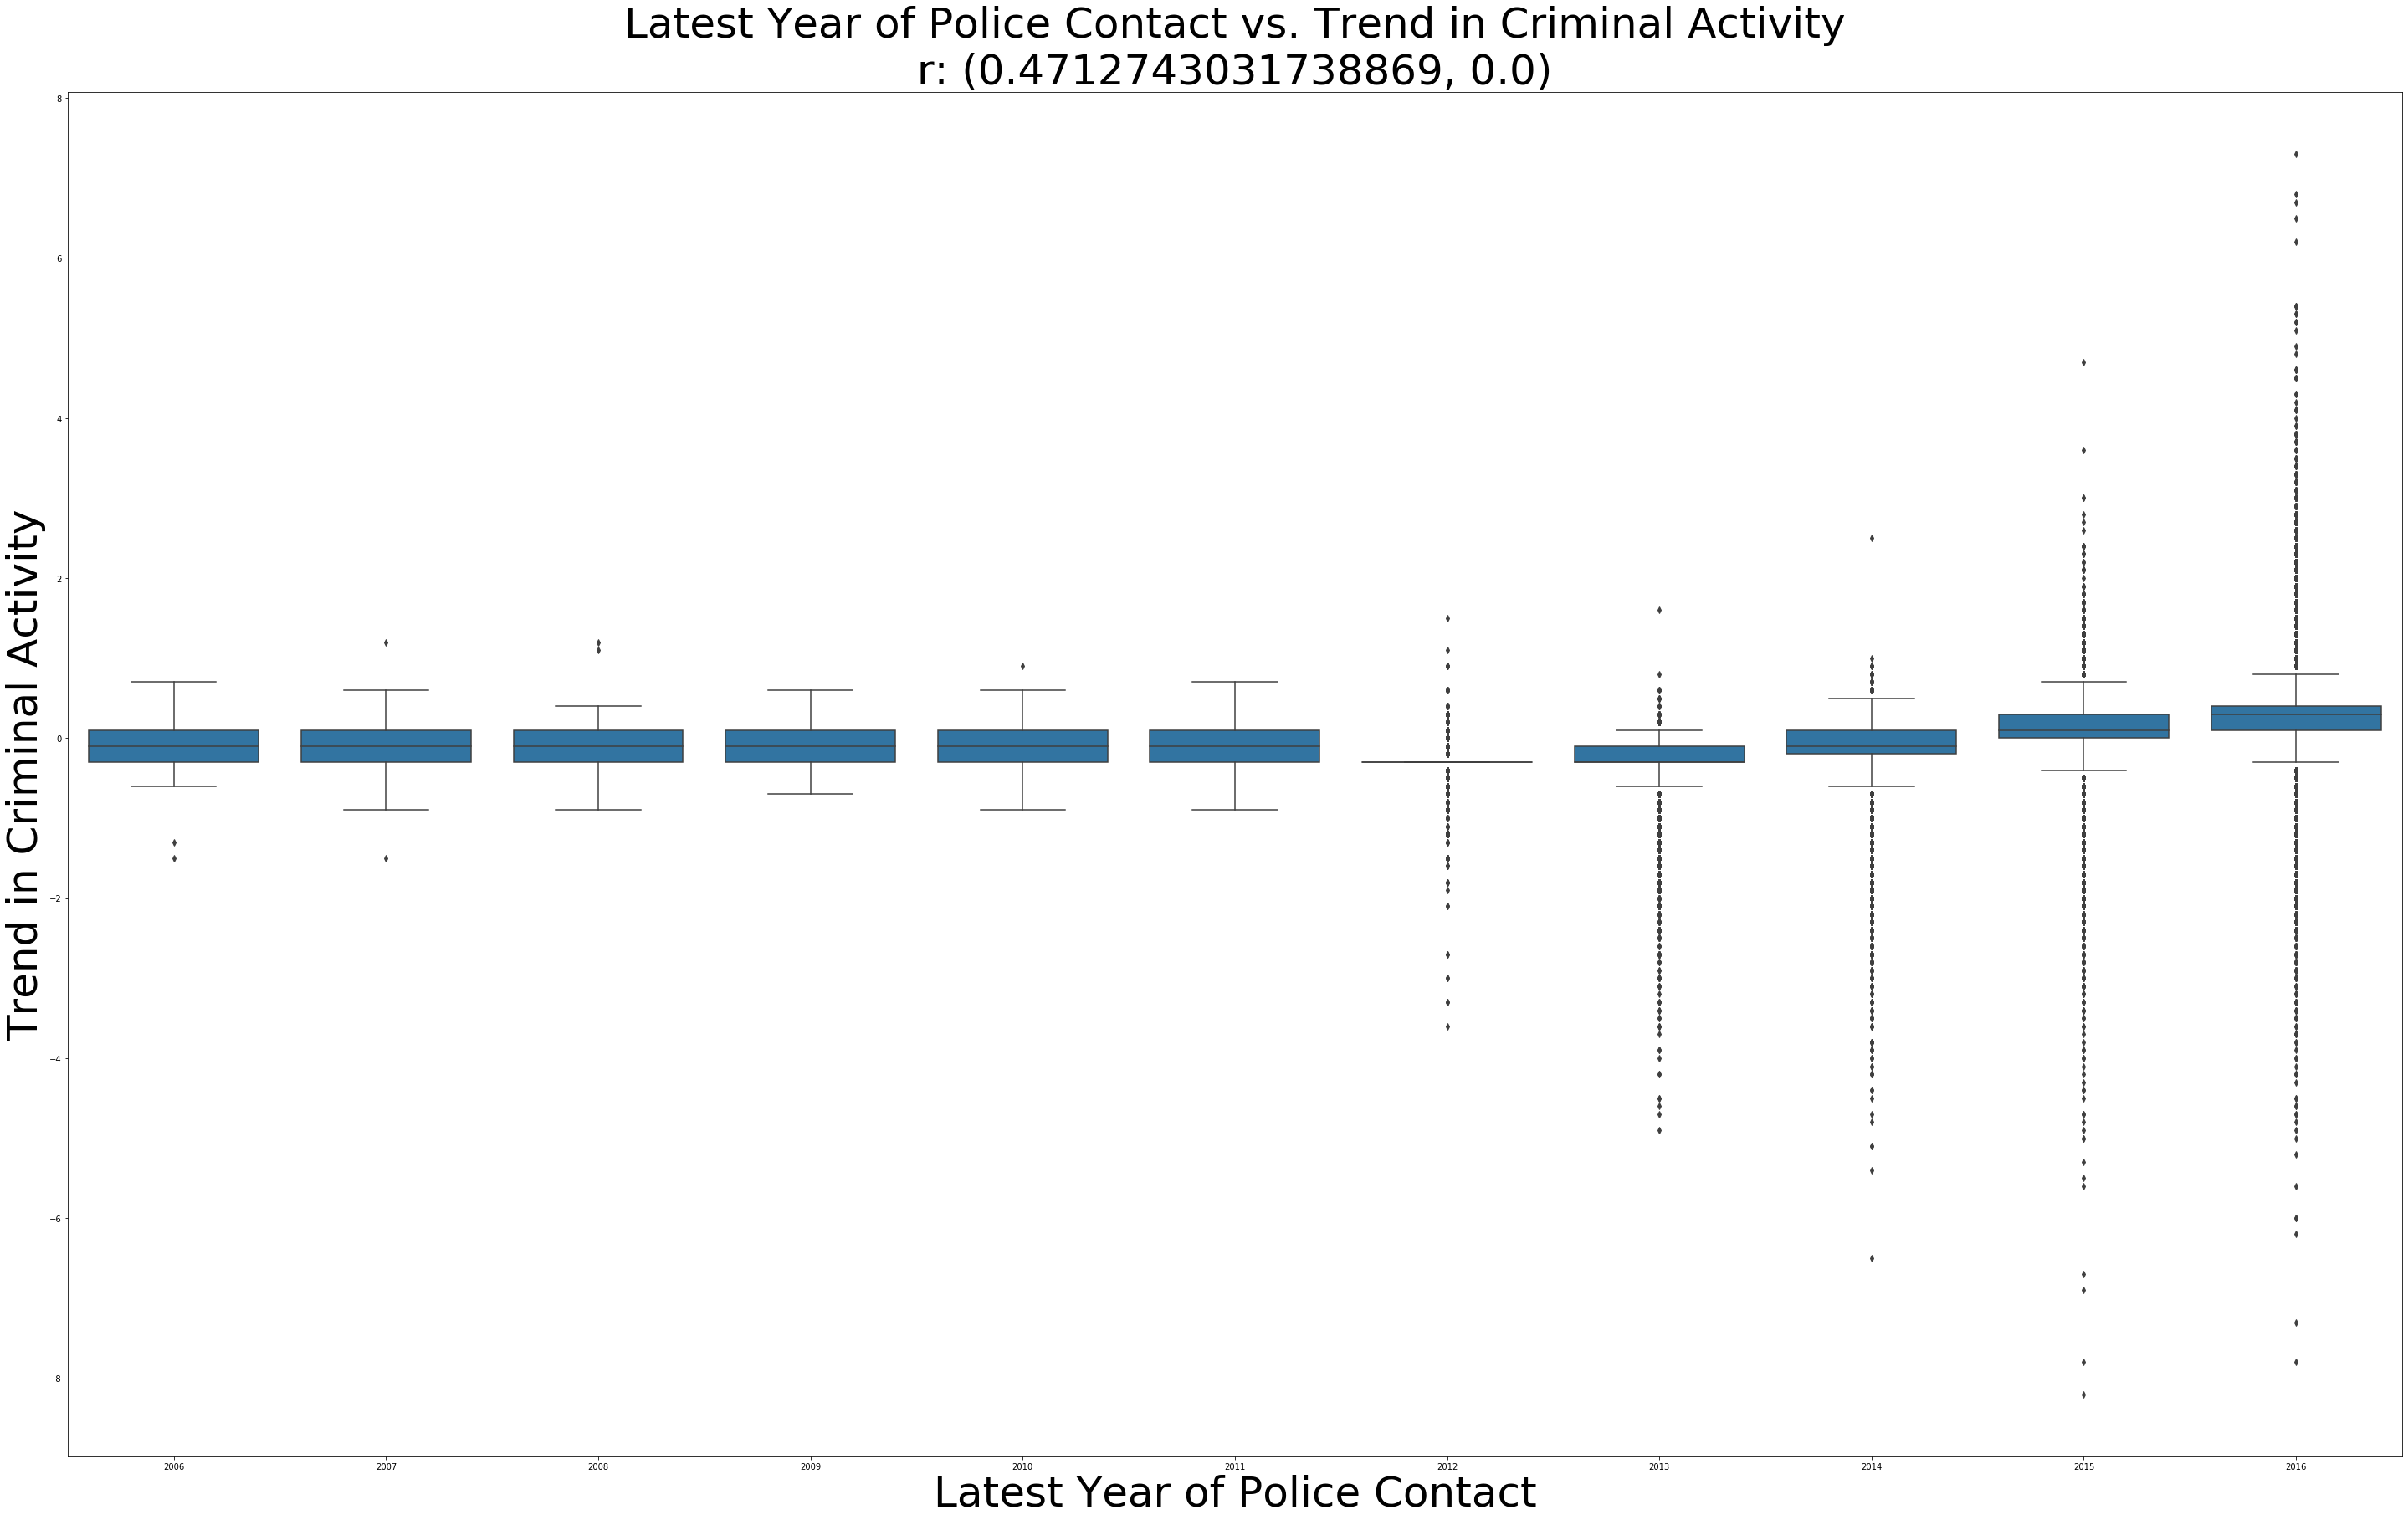

In [10]:
plt.subplots(figsize=(50, 30))
sns.boxplot(df['LATEST DATE'].values, df['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY'], color='#1f77b4')
plt.title("Latest Year of Police Contact vs. Trend in Criminal Activity\nr: " + str(latest_r), fontsize=50)
plt.xlabel("Latest Year of Police Contact", fontsize=50)
plt.ylabel("Trend in Criminal Activity", fontsize=50)
plt.show()

## 2.2 The effect of arrest counts on 'trend':
Below are three scatterplots. They depict one of three types of arrest count (weapons, narcotics, domestic) vs. 'trend'. These plots reveal they are unlikely to be helpful in any model. We note that the distribution of `WEAPONS ARR CNT` is much tighter than those of `NARCOTICS ARR CNT` and `DOMESTIC ARR CNT`. Illinois has relatively strict gun control laws; possession of a loaded gun with no FOID/CCL card carries a penalty of 1-3 years in prison with steeper penalties for repeat offenders and other aggravating factors. It is likely that subjects don't accumulate many weapons charges due to the high probability of lengthy incarceration that accompanies each arrest.

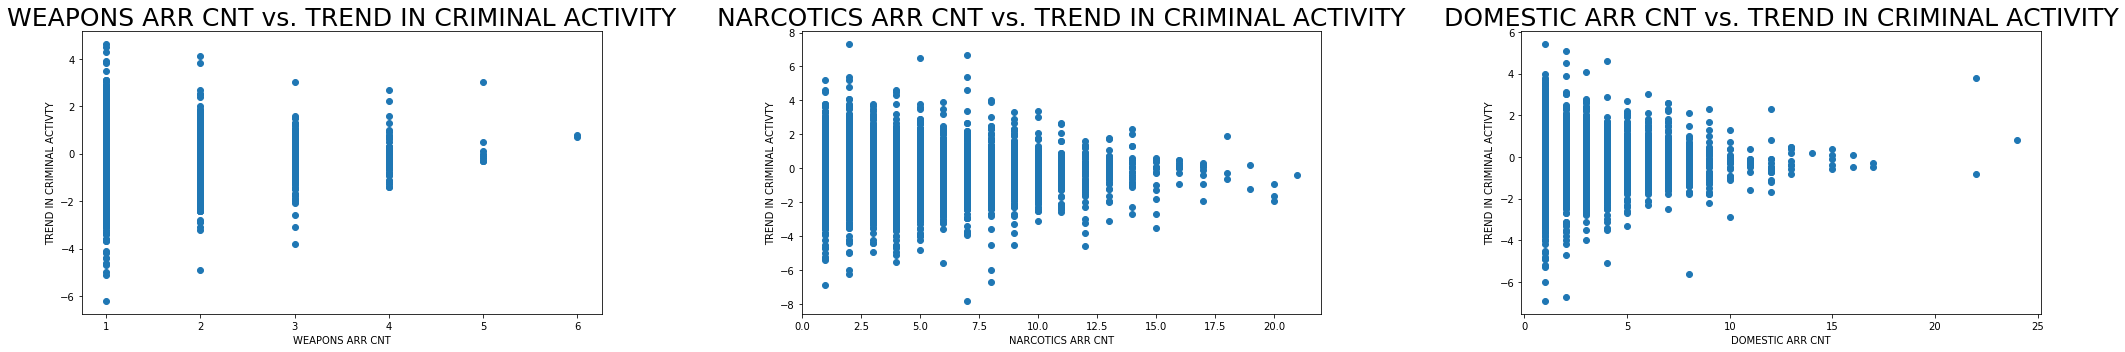

In [11]:
plt.subplots(figsize=(30, 5))
weapons_arr_cnt = df[['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY',\
                      'WEAPONS ARR CNT']].dropna().values
narcotics_arr_cnt = df[['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY',\
                       'NARCOTICS ARR CNT']].dropna().values
domestic_arr_cnt = df[['PREDICTOR RAT TREND IN CRIMINAL ACTIVITY',\
                       'DOMESTIC ARR CNT']].dropna().values
plt.subplot(1,3,1)
plt.scatter(weapons_arr_cnt[:,1], weapons_arr_cnt[:,0])
plt.title("WEAPONS ARR CNT vs. TREND IN CRIMINAL ACTIVITY", fontsize=25)
plt.xlabel("WEAPONS ARR CNT")
plt.ylabel("TREND IN CRIMINAL ACTIVTY")

plt.subplot(1,3,2)
plt.scatter(narcotics_arr_cnt[:,1], narcotics_arr_cnt[:,0])
plt.title("NARCOTICS ARR CNT vs. TREND IN CRIMINAL ACTIVITY", fontsize=25)
plt.xlabel("NARCOTICS ARR CNT")
plt.ylabel("TREND IN CRIMINAL ACTIVTY")

plt.subplot(1,3,3)
plt.scatter(domestic_arr_cnt[:,1], domestic_arr_cnt[:,0])
plt.title("DOMESTIC ARR CNT vs. TREND IN CRIMINAL ACTIVITY", fontsize=25)
plt.xlabel("DOMESTIC ARR CNT")
plt.ylabel("TREND IN CRIMINAL ACTIVTY")

plt.tight_layout()
plt.show()

## 2.2 Recent arrest dates and 'trend':
Here we come across more related variables. `LATEST WEAPON ARR DATE` has the strongest correlation we have seen yet with 'trend': $.41$. `LATEST DOMESTIC ARR DATE` and `LATEST NARCOTICS ARR DATE` have correlations of $.12$ and $.14$, respectively.

**Question:** If 'trend' is a function of fields like the above, does it weight weapons arrests more heavily?


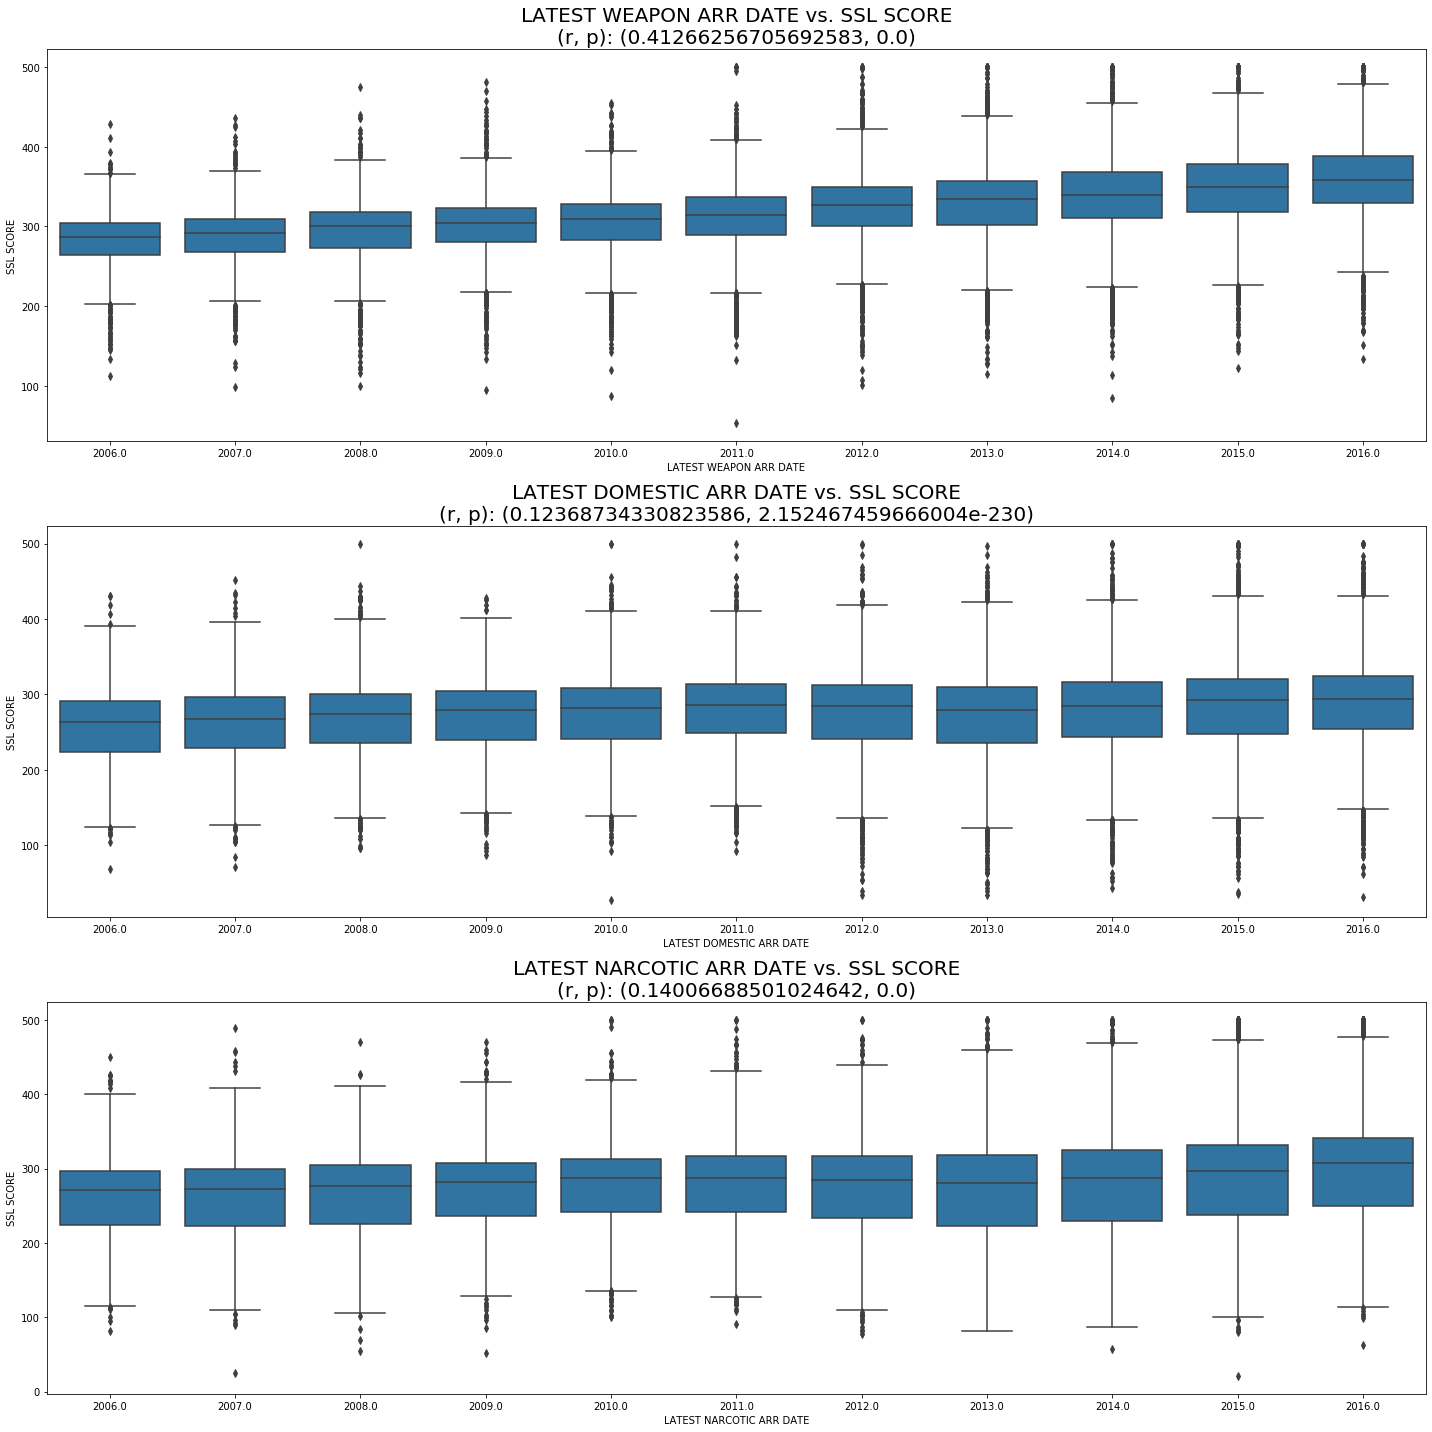

In [12]:
plt.subplots(figsize=(20, 20))

plt.subplot(3,1,1)
weapons_arrestees = df[['SSL SCORE','LATEST WEAPON ARR DATE']].dropna(subset=['LATEST WEAPON ARR DATE'])
weapon_r = pearsonr(weapons_arrestees['LATEST WEAPON ARR DATE'].values, weapons_arrestees['SSL SCORE'].values)
sns.boxplot(weapons_arrestees['LATEST WEAPON ARR DATE'], weapons_arrestees['SSL SCORE'], color='#1f77b4')
plt.title("LATEST WEAPON ARR DATE vs. SSL SCORE\n(r, p): "+str(weapon_r), fontsize=20)

plt.subplot(3,1,2)
domestic_arrestees = df[['SSL SCORE','LATEST DOMESTIC ARR DATE']].dropna(subset=['LATEST DOMESTIC ARR DATE'])
domestic_r = pearsonr(domestic_arrestees['LATEST DOMESTIC ARR DATE'].values, domestic_arrestees['SSL SCORE'].values)
sns.boxplot(domestic_arrestees['LATEST DOMESTIC ARR DATE'], domestic_arrestees['SSL SCORE'], color='#1f77b4')
plt.title("LATEST DOMESTIC ARR DATE vs. SSL SCORE\n(r, p): "+str(domestic_r), fontsize=20)

plt.subplot(3,1,3)
narcotic_arrestees = df[['SSL SCORE','LATEST NARCOTIC ARR DATE']].dropna(subset=['LATEST NARCOTIC ARR DATE'])
narcotic_r = pearsonr(narcotic_arrestees['LATEST NARCOTIC ARR DATE'].values, narcotic_arrestees['SSL SCORE'].values)
sns.boxplot(narcotic_arrestees['LATEST NARCOTIC ARR DATE'], narcotic_arrestees['SSL SCORE'], color='#1f77b4')
plt.title("LATEST NARCOTIC ARR DATE vs. SSL SCORE\n(r, p): "+str(narcotic_r), fontsize=20)

plt.tight_layout()
plt.show()


# 3. Age
Both Upturn and the New York Times found that the variable most closely related to SSL score was age. Concretely, the New York Times<sup>1</sup> found that
>The most significant characteristic for computing an S.S.L. risk score is the age of a potential victim or offender. For every decade of age, the risk score declined by about 40 points. Practically speaking, this variable limits the list to young people: No one older than 30 falls within the highest-risk category with a score at or above 480.

And in parallel to the Times, Upturn<sup>2</sup> found that
>the most important factor in an individual’s SSL score was their age: age accounts for roughly 89% of variance in SSL scores. In other words, the score mostly just reflects each person’s age.

So, age is a crucial ingredient for modeling SSL score.

<sup>1</sup>https://www.nytimes.com/2017/06/13/upshot/what-an-algorithm-reveals-about-life-on-chicagos-high-risk-list.html

<sup>2</sup>https://medium.com/equal-future/how-strategic-is-chicagos-strategic-subjects-list-upturn-investigates-9e5b4b235a7c

Below we have a scatter plot of age group vs. SSL score. We replicate Upturn's finding that age accounts for $.9412^2 \sim 89$% of the variance in SSL scores, although we are unsure whether they used the same age-group-to-continuous-variable conversion. Ours was:
<ol start="0">
    <li> 'less than 20' </li>
    <li> '20-30' </li>
    <li> '30-40' </li>
    <li> '40-50' </li>
</ol> 

and so on. See the function `age_converter` for details.

The fields `AGE TO` and `AGE GROUP` contain the same values. Since `AGE CURR` values are higher or equal, I will assume it has been updated more recently and will use it exclusively.

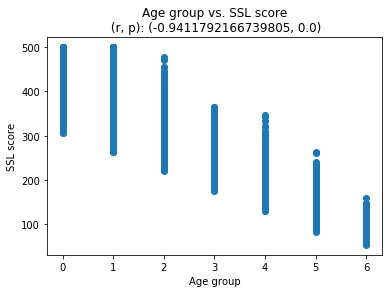

In [13]:
age_vs_ssl = df[['SSL SCORE','PREDICTOR RAT AGE AT LATEST ARREST']].dropna()
age_vs_ssl['PREDICTOR RAT AGE AT LATEST ARREST']=\
    age_vs_ssl['PREDICTOR RAT AGE AT LATEST ARREST'].apply(age_converter)
scores, ages = age_vs_ssl.values[:,1], age_vs_ssl.values[:,0]
age_r = pearsonr(scores, ages)
plt.scatter(scores, ages)
plt.title("Age group vs. SSL score\n (r, p): " + str(age_r))
plt.xlabel("Age group")
plt.ylabel("SSL score")
plt.show()

# 3.1 The relationship between `AGE CURR` and `PREDICTOR RAT AGE AT LATEST ARREST`
About 77% of subjects are, as of May 1, 2017 when the data was last updated, the same age as when they were last arrested. Interestingly, 924 subjects are listed to have a current age less than their age at the time of their latest arrest. Since this is impossible, it is possible when a subject is arrested, their current age is not updated. The 2D histogram below indicates that there is a high density of subjects along the line `AGE CURR` = `PREDICTOR RAT AGE AT LATEST ARREST`, with nearly over a quarter (28.6%) of subjects between in the age group 20-30 and having been arrested last while in that age group.

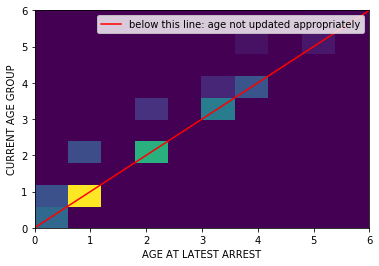

In [14]:
ages = df[['PREDICTOR RAT AGE AT LATEST ARREST', 'AGE CURR']].dropna()
ages['PREDICTOR RAT AGE AT LATEST ARREST'] = ages['PREDICTOR RAT AGE AT LATEST ARREST'].apply(age_converter)
ages['AGE CURR'] = ages['AGE CURR'].apply(age_converter)
agevals = ages.values
plt.hist2d(agevals[:,0], agevals[:,1])
plt.xlabel("AGE AT LATEST ARREST")
plt.ylabel("CURRENT AGE GROUP")
plt.plot([0,6], [0,6], color='r', label="below this line: age not updated appropriately")
plt.legend(loc='upper right')
plt.show()

In [15]:
len(ages[(ages['AGE CURR'] == 1) &\
         (ages['PREDICTOR RAT AGE AT LATEST ARREST'] == 1)])/len(ages)

0.28575444232506775

# 4. Location
Latitude and longitude data are provided for location of the subject's most recent arrest, but only for 224,235 subjects, or $56.24$% of the total. The situation is not much improved for census tract and community area fields, which are non-null for just 227,763 and 224,311 rows, respectively. Since 398,582 subjects have a non-null entry for `PREDICTOR RAT AGE AT LATEST ARREST`, we assume at least 398,582 subjects have been arrested, and therefore these location fields are woefully incomplete.

Below is a heatmap of of arrests based on the available latitude and longitude data. The one yellow square is near East and West Garfield Park, two of the highest-crime neighborhoods in Chicago.

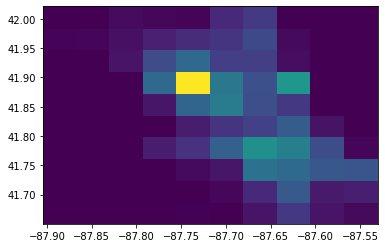

In [16]:
locations = df[['LONGITUDE', 'LATITUDE']].dropna().values
plt.hist2d(locations[:,0], locations[:,1])
plt.show()

# 5. Race and Gender
Per the CPD, the algorithm does not take this sensitive information as input. Nevertheless, some analysis is recorded here for posterity, although it does not suggest any significant relationship between SSL score, race, and sex.

The field `SEX CODE CD` has value `M` if the subject is male, `F` if the subject is female, and `X` in 57 cases. Presumably in these latter cases either the subject's sex was not recorded or the subject chose not to identify as male or female.

The field `RACE CODE CD` uses the encoding below. There are 1899 individuals for whom race is unknown.
<ol>
    <li> BLK - Black
    <li> WHI - White
    <li> API - Asian/Pacific Islander
    <li> WBH - Black Hispanic
    <li> WWH - White Hispanic
    <li> I - American Indian/Alaskan Native
    <li> U - Unknown
</ol>

Text(0, 0.5, 'Mean SSL score')

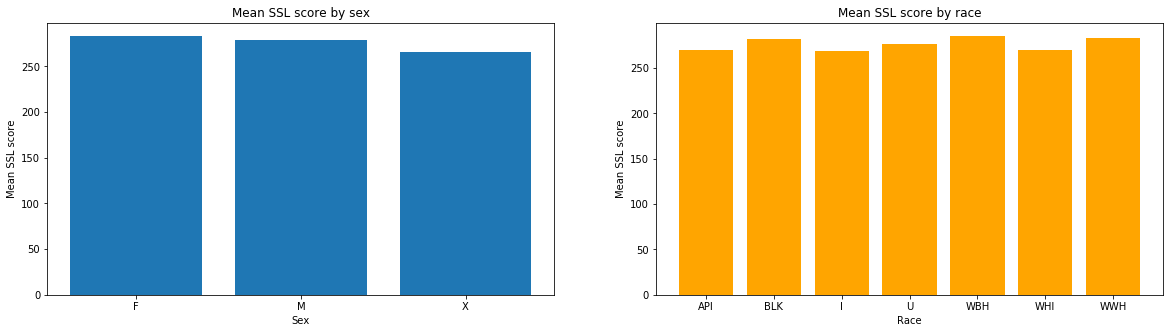

In [17]:
plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
sex_means = df[['SEX CODE CD','SSL SCORE']].groupby(['SEX CODE CD']).mean()
plt.bar(list(range(3)), sex_means['SSL SCORE'].values, tick_label=sex_means.index)
plt.title("Mean SSL score by sex")
plt.xlabel("Sex")
plt.ylabel("Mean SSL score")

plt.subplot(1,2,2)
race_means = df[['RACE CODE CD','SSL SCORE']].groupby(['RACE CODE CD']).mean()
plt.bar(list(range(7)), race_means['SSL SCORE'].values, tick_label=race_means.index,color='orange')
plt.title("Mean SSL score by race")
plt.xlabel("Race")
plt.ylabel("Mean SSL score")